In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

## The process is broken into three main parts:
1. Transform raw dataset into something that can be used to model time series:
    * Prepare data
    * Transform dataset to a supervised learning problem - Identify features and response variable
    * Divide into training/test sets
2. Fit an LSTM model
3. Making a forecast & interpreting results

## 1.a. Preparing data

In [3]:
# The data set has the date separated into three columns - we want to reformat the date to set it as our index
from datetime import datetime

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('/Users/ainulrosli/Google Drive/ClarkForraw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True) #there is an index column "No" that we don't need, so we drop it

In [4]:
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours as there are no observations, for the remaining NAs in the dataset, we fill with 0
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('/Users/ainulrosli/Google Drive/pollution.csv') # 1st part done - We have prepared the data

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## 1.b. Transforming dataset to a supervised learning problem

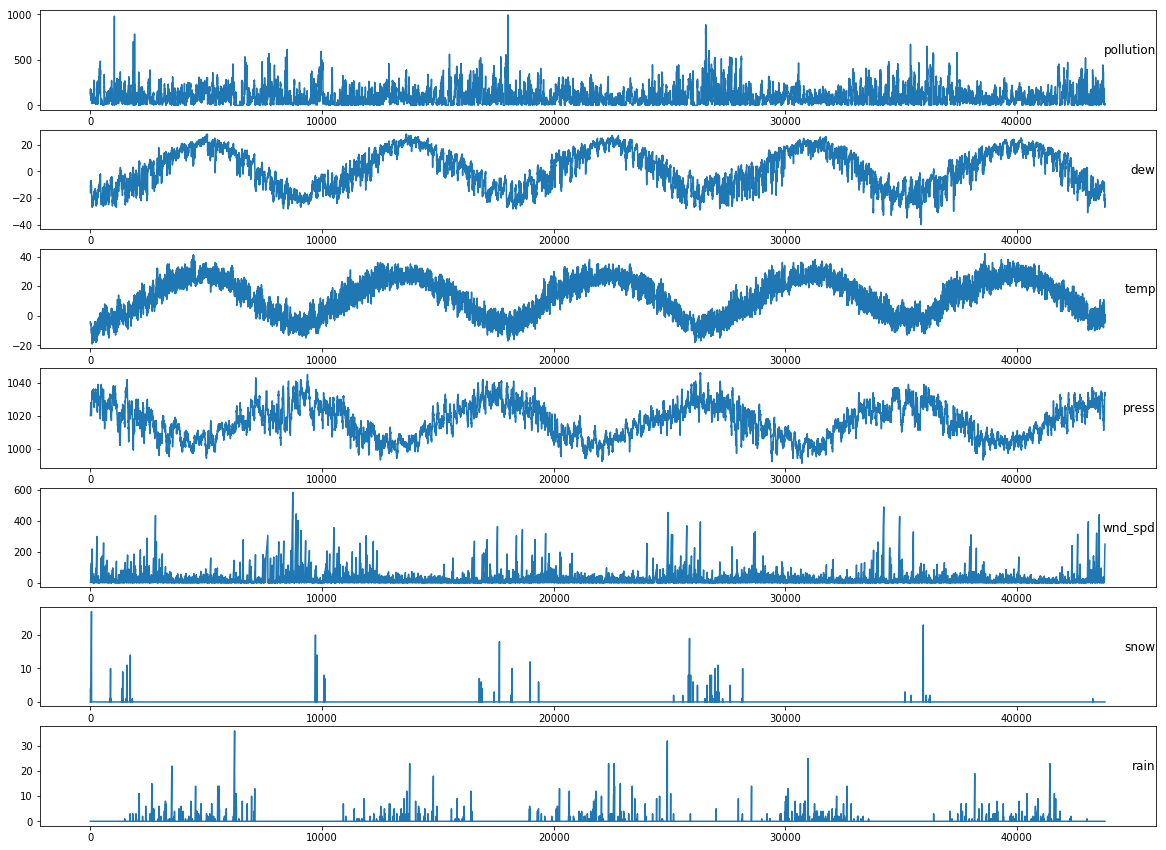

In [6]:
dataset = read_csv('/Users/ainulrosli/Google Drive/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(20,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [7]:
# Can do it manually but efficient to create a function to transform a series to a supervised problem
# The function's key components:
# -the pandas shift() function and how it can be used to automatically define supervised learning datasets from time series data.
# -reframe a univariate time series into one-step and multi-step supervised learning problems.
# -reframe multivariate time series into one-step and multi-step supervised learning problems.

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [9]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## 1.c. Divide into train and test sets

#### LSTM 
For LSTM we must transform the input patterns from a 2D array (1 column with 9 rows) to a 3D array comprised of [rows, timesteps, columns] where timesteps is 1 because we only have one timestep per observation on each row.

In [10]:
# Split dataset
values = reframed.values
n_train_hours = 35039 # 365 days * 24 hours * 4 years - 1 (starts with 0)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35039, 1, 8) (35039,) (8760, 1, 8) (8760,)


## 2. Model Fitting
* We are choosing LSTM because it is widely used and shows good results for multivariate time-forecasting
* You can experiment with other sequential models that are available on the Keras website here: https://keras.io/getting-started/sequential-model-guide/

Train on 35039 samples, validate on 8760 samples
Epoch 1/40
4s - loss: 0.0343 - val_loss: 0.0295
Epoch 2/40
3s - loss: 0.0142 - val_loss: 0.0139
Epoch 3/40
3s - loss: 0.0139 - val_loss: 0.0131
Epoch 4/40
3s - loss: 0.0139 - val_loss: 0.0128
Epoch 5/40
3s - loss: 0.0139 - val_loss: 0.0128
Epoch 6/40
3s - loss: 0.0139 - val_loss: 0.0128
Epoch 7/40
2s - loss: 0.0138 - val_loss: 0.0129
Epoch 8/40
3s - loss: 0.0138 - val_loss: 0.0130
Epoch 9/40
3s - loss: 0.0138 - val_loss: 0.0131
Epoch 10/40
3s - loss: 0.0138 - val_loss: 0.0130
Epoch 11/40
3s - loss: 0.0138 - val_loss: 0.0131
Epoch 12/40
3s - loss: 0.0139 - val_loss: 0.0132
Epoch 13/40
3s - loss: 0.0138 - val_loss: 0.0131
Epoch 14/40
3s - loss: 0.0137 - val_loss: 0.0132
Epoch 15/40
3s - loss: 0.0138 - val_loss: 0.0133
Epoch 16/40
3s - loss: 0.0138 - val_loss: 0.0133
Epoch 17/40
3s - loss: 0.0138 - val_loss: 0.0134
Epoch 18/40
2s - loss: 0.0137 - val_loss: 0.0131
Epoch 19/40
3s - loss: 0.0137 - val_loss: 0.0131
Epoch 20/40
3s - loss: 0.0138

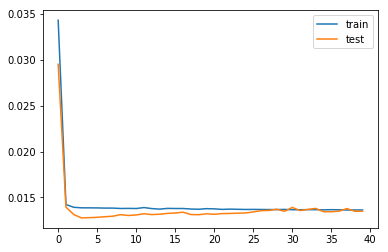

In [11]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## 3. Using Model to Predict and Interpreting Results

In [12]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling to obtain actual values
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.055


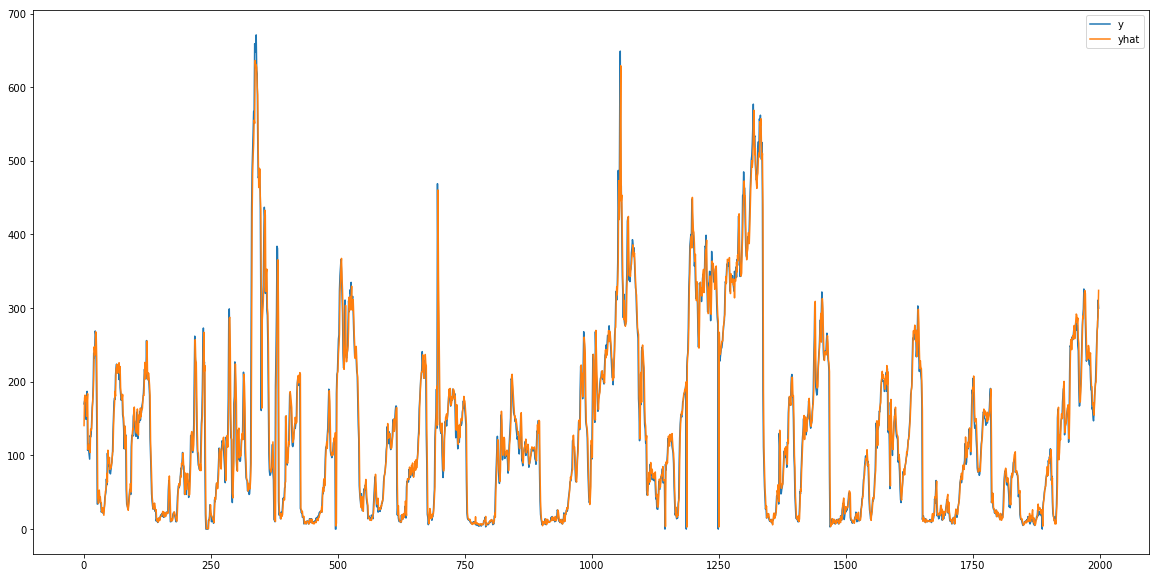

In [145]:
fig = pyplot.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(inv_y[1:2000],label='y')
ax1.plot(inv_yhat[1:2000],label='yhat')
pyplot.legend()
pyplot.show()

## Tuning LSTM Parameters in Keras
* Tune the number of epochs: Simply change the number
* Tune the batch size
* Tune the number of neurons

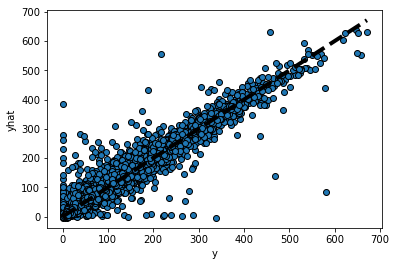

In [13]:
fig, ax = pyplot.subplots()
ax.scatter(inv_y, inv_yhat, edgecolors=(0, 0, 0))
ax.plot([inv_y.min(), inv_y.max()], [inv_y.min(), inv_y.max()], 'k--', lw=4)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
pyplot.show()

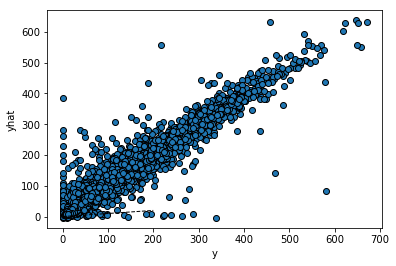

In [14]:
fig, ax = pyplot.subplots()
ax.scatter(inv_y, inv_yhat, edgecolors=(0, 0, 0))
ax.plot([inv_y.min(), 200], [inv_y.min(), 20], 'k--', lw=1)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
pyplot.show()